# Differential Voltage Analysis – Reproduction of Cui et al. (2024)

This notebook reproduces and explores the **differential voltage analysis (dV/dQ)** presented in:

**Cui et al.**, *"Data-Driven Analysis of Battery Formation Reveals the Role of Electrode Utilization in Extending Cycle Life"*, *Joule*, 2024.  
📄 [Paper link](https://www.cell.com/joule/abstract/S2542-4351(24)00353-2)  
📂 [GitHub repository](https://github.com/cx26/formation-analysis)

---
## Purpose

The main goal of this notebook is just to **run through** the original dV/dQ and full-cell fitting code from Cui et al. (2024),  
see how it works, and get a better feel for the logic behind it.

I made a few small changes (e.g. file paths, parameters) so it works locally,  
and added some comments for myself to better understand each step.

This should help later if I want to write my own functions or adapt parts of it for other data.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import sys

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
print(os.getcwd()) # to know where I am...

current_dir = os.getcwd()
src_dir = os.path.join(
    current_dir,
    '..',  # back to the parent library
    'External_repos',
    'Repo-formation-analysis-main',
    'src'
)

# Add to the module search path
sys.path.append(src_dir)

from DVF_functions import *

D:\FUSE 2025 SUM\battery-analysis-project\Notebooks


### Data loading  

In [4]:
data_dir = os.path.join(src_dir, '..')
pe = pd.read_csv(os.path.join(data_dir, 'data/dvf_data/pe_cycle_1.csv'))
ne = pd.read_csv(os.path.join(data_dir,'data/dvf_data/ne_cycle_020224.csv'))

### Prepare the half/full cell data

In [5]:
# Define smoothing window size; larger values result in stronger smoothing
window = 9

# Apply smoothing to positive and negative electrode data
df_pe = smooth_pe(pe, window)  # Processed positive electrode data
df_ne = smooth_ne(ne, window)  # Processed negative electrode data

# Smoothing is applied to the voltage–capacity (V–Q) curves
# before computing the derivative (dV/dQ), in order to suppress measurement noise.
# This is a standard preprocessing step in differential voltage analysis,
# as numerical gradients are highly sensitive to noisy data and can produce erratic results.

In [7]:
# Load experimental data for two full cells
# The function process_full_test() performs preprocessing on the raw data,
# including unit conversion, interpolation, outlier removal, and data completion
df_full_169 = process_full_test(os.path.join(data_dir, 'data/dvf_data/full_C_20_169.csv'))
df_full_106 = process_full_test(os.path.join(data_dir, 'data/dvf_data/full_C_20_106.csv'))

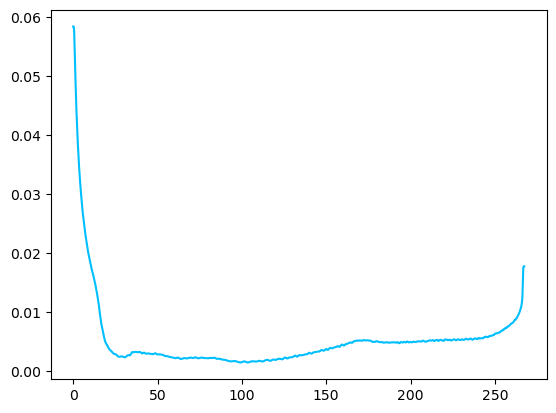

In [12]:
# Compute and plot the dV/dQ curves for a selected full cell
df = df_full_169

dvdq = np.divide(np.gradient(df['Voltage_sm']), np.gradient(df['Q']))
# df['Q'] returns the column named `'Q'` from DataFrame `df`

plt.plot(df['Q'], dvdq, color="deepskyblue") 

dvdq = np.divide(np.gradient(df['Voltage_aligned']), np.gradient(df['Q']))
plt.plot(df['Q'], dvdq, color="salmon") 

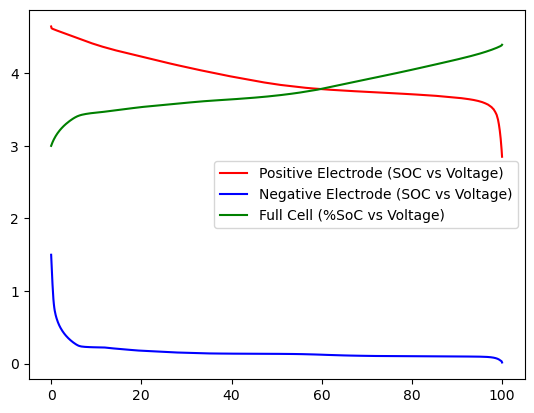

In [20]:
plt.plot(df_pe['SOC_aligned'], df_pe['Voltage_aligned'], color = 'red', label='Positive Electrode (SOC vs Voltage)')
# Plot the positive electrode's aligned State of Charge (SOC) vs aligned voltage.

plt.plot(df_ne['SOC_aligned'], df_ne['Voltage_aligned'], color="blue",label='Negative Electrode (SOC vs Voltage)')

plt.plot(df_full_169['Q']*100/df_full_169['Q'].max(), df_full_169.Voltage_aligned, color='green', label='Full Cell (%SoC vs Voltage)')

plt.legend()
# df_full_169['Q']: the full cell's capacity curve (x-axis)
# * 100 / .max(): turns Q into % SoC
# df_full_169['Voltage_aligned']: aligned voltage of the full cell

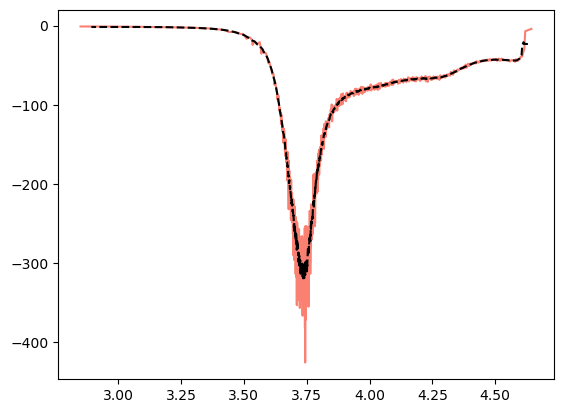

In [15]:
plot_dqdv(df_pe, '-', 'salmon', 'Voltage_aligned')
# Aligned positive electrode dQ/dV curve
plot_dqdv(df_pe, '--', 'k', 'Voltage_sm')
# Smoothed raw positive electrode dQ/dV curve

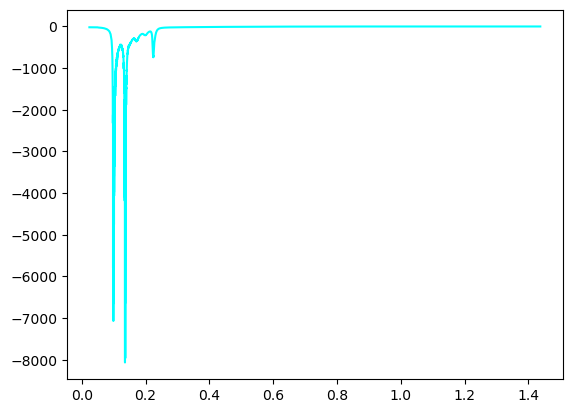

In [24]:
plot_dqdv(df_ne, '-', 'cyan', 'Voltage_sm')

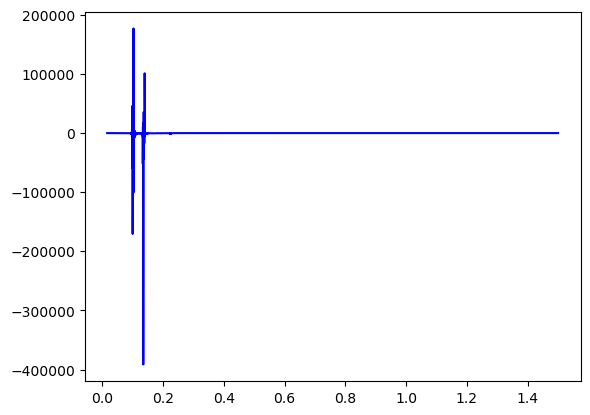

In [25]:
plot_dqdv(df_ne, '-', 'b', 'Voltage_aligned')

(0.0, 0.03)

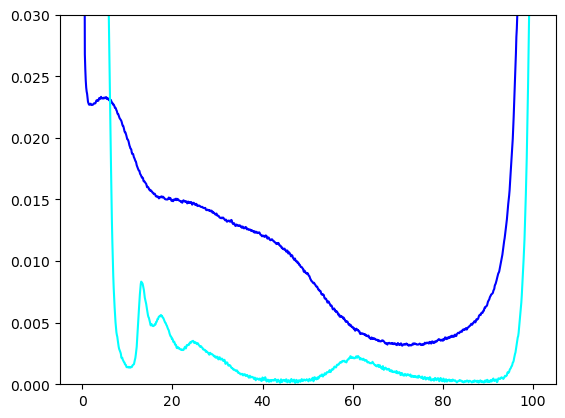

In [17]:
fig, ax = plt.subplots()
plot_dvdq_ele(df_pe, '-', 'b', 'Voltage_sm', ax)
plot_dvdq_ele(df_ne, '-', 'cyan', 'Voltage_sm', ax)
plt.ylim([0, 0.03])

In [18]:
voltage = 'Voltage_sm'  # Use the smoothed voltage column for fitting

# Define parameter bounds for the optimization (5 parameters total)
bounds = [(200, 299), (200, 300), (0, 120), (0, 120), (0, 120)]

full_cell = df_full_169  # Select the full-cell data to be fitted

# Use SHGO (Simplicial Homology Global Optimization) to minimize the error function
# It searches globally for the best-fit parameters by evaluating many combinations
# 'args' passes the positive electrode, negative electrode, full-cell data, and voltage label to the error function
res_169 = scipy.optimize.shgo(
    simulation_error,
    bounds,
    args=(df_pe, df_ne, df_full_169, voltage)
)

# res_169.fun → Final minimized value of the error function (the smaller, the better)
# res_169.x   → Best-fit parameter values that minimize the error
res_169

 message: Optimization terminated successfully.
 success: True
     fun: 0.002454246989340246
    funl: [ 2.454e-03]
       x: [ 2.990e+02  2.957e+02  1.531e+00  9.716e+01  3.334e+00]
      xl: [[ 2.990e+02  2.957e+02  1.531e+00  9.716e+01  3.334e+00]]
     nit: 1
    nfev: 530
   nlfev: 497
   nljev: 81
   nlhev: 0

In [19]:
voltage = 'Voltage_sm' 
bounds = [(200,  400), (200, 400), (0, 120), (0, 120), (0, 120)]
full_cell = df_full_106
res_106 =scipy.optimize.shgo(simulation_error, bounds, args=(df_pe, df_ne, df_full_106, voltage))
res_106

 message: Optimization terminated successfully.
 success: True
     fun: 0.0032893966442983764
    funl: [ 3.289e-03]
       x: [ 3.069e+02  2.923e+02  1.042e+00  9.314e+01  1.880e+00]
      xl: [[ 3.069e+02  2.923e+02  1.042e+00  9.314e+01  1.880e+00]]
     nit: 1
    nfev: 484
   nlfev: 451
   nljev: 73
   nlhev: 0

### Functions to visualize the fit 

(0.0042991243710085,
 92.06432193043959,
 5.62478204859967,
 267.36123729999997,
 291.9056086980794)

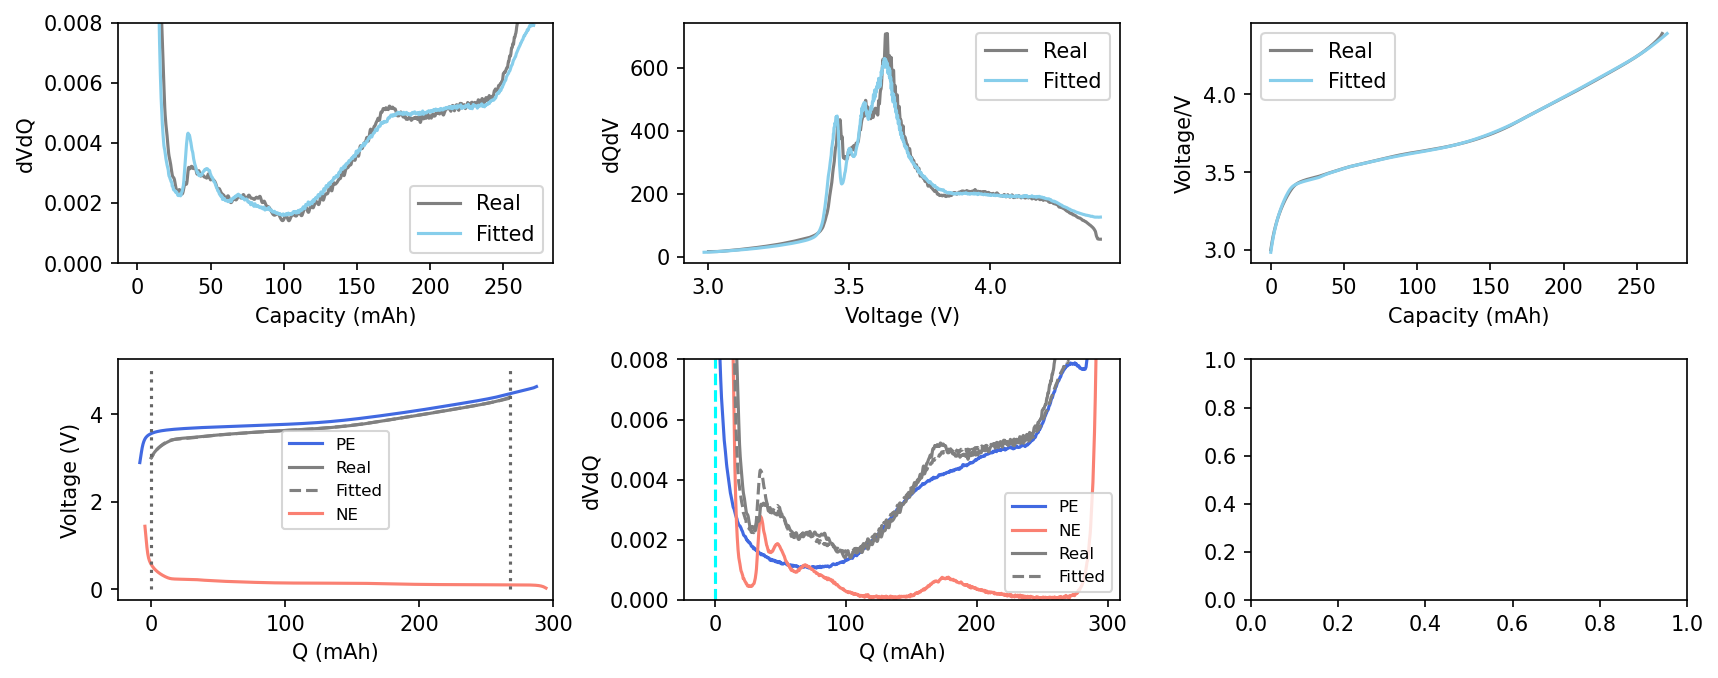

In [20]:
process_fitting_results(res_169, df_full_169, df_ne, df_pe, 1, voltage)
# plt.savefig('fitting_results_slow.pdf', transparent = True, bbox_inches='tight')

(0.00522292155716894,
 84.41259650390273,
 5.597992739284976,
 253.98714700000002,
 275.427112550564)

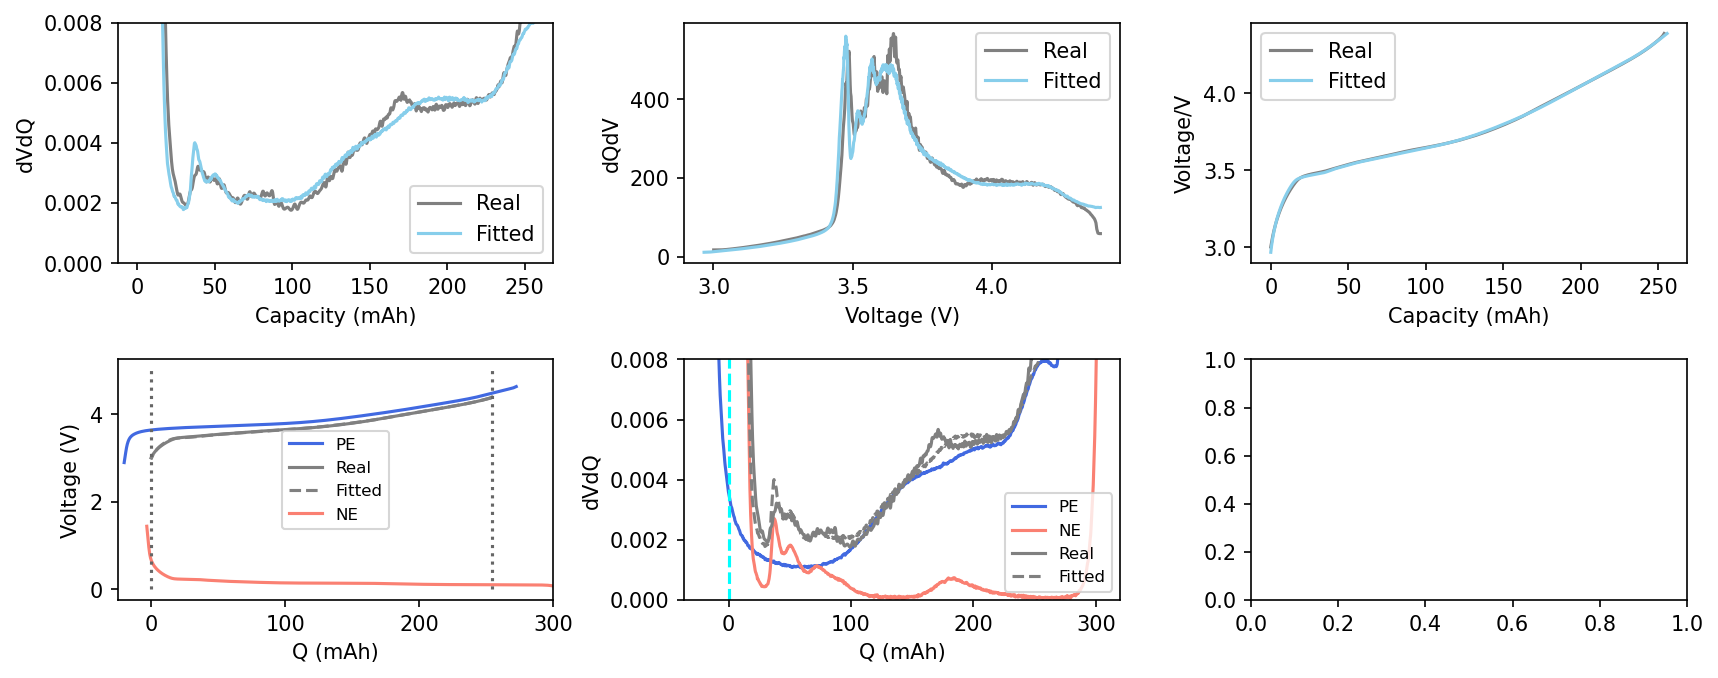

In [21]:
process_fitting_results(res_106, df_full_106, df_ne, df_pe, 1, voltage)
# plt.savefig('fitting_results_fast.pdf', transparent = True, bbox_inches='tight')